In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from grav_lens import get_datasets

import os

max_files = -1
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)

Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [8]:
import pickle
from utils import CustomMinMaxScaler
from utils import filtering

# Cargar el IPCA desde un archivo pickle
with open('minmaxscaler.pkl', 'rb') as f:
    minmaxscaler = pickle.load(f)

In [9]:
# Para el PCA
from sklearn.decomposition import IncrementalPCA

n_components = batch_size # el maximo

# Crear y aplicar IncrementalPCA para baja frecuencia
ipca_low = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Crear y aplicar IncrementalPCA para alta frecuencia
ipca_high = IncrementalPCA(n_components=n_components, batch_size=batch_size)

In [10]:
for X_batch, y_batch in train_dataset:
    y_batch = minmaxscaler.transform(y_batch) # [0, 1]

    low_freq_batch, high_freq_batch = filtering.process_batch_filters(y_batch.numpy(), cutoff=0.05)
    
    # Aplanar las imágenes y apilarlas para baja frecuencia
    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_freq_batch])
    
    # Aplanar las imágenes y apilarlas para alta frecuencia
    high_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in high_freq_batch])
    
    # Aplicar el ajuste incremental al IPCA para baja frecuencia
    ipca_low.partial_fit(low_freq_stack)
    
    # Aplicar el ajuste incremental al IPCA para alta frecuencia
    ipca_high.partial_fit(high_freq_stack)


Se necesitan 32 componentes para explicar el 68% de la varianza en baja frecuencia.


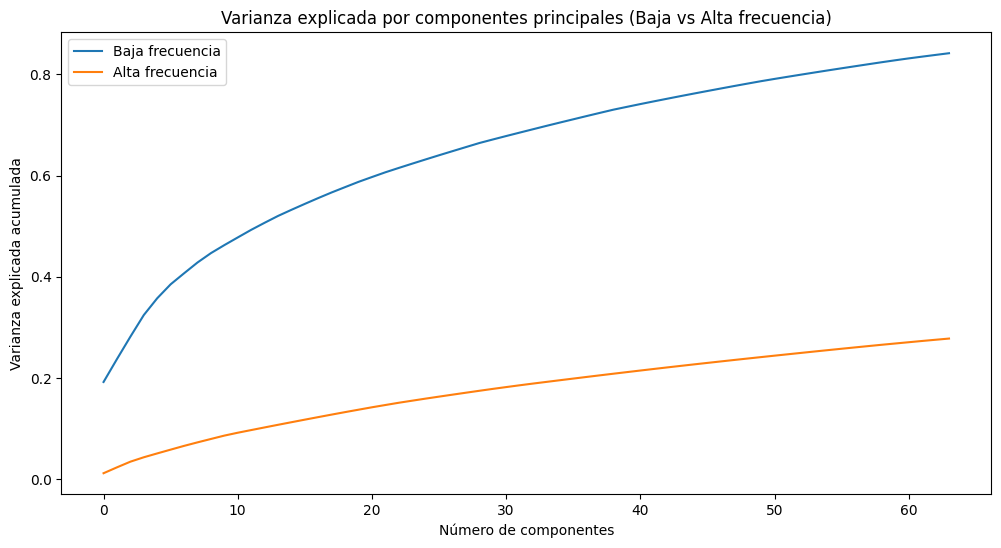

In [11]:

# Calcular la varianza explicada acumulada para baja frecuencia
explained_variance_ratio_low = np.cumsum(ipca_low.explained_variance_ratio_)

# Calcular la varianza explicada acumulada para alta frecuencia
explained_variance_ratio_high = np.cumsum(ipca_high.explained_variance_ratio_)

# Imprimir la varianza explicada acumulada para baja frecuencia
for i, var in enumerate(explained_variance_ratio_low):
    if var >= 0.68:
        print(f"Se necesitan {i+1} componentes para explicar el 68% de la varianza en baja frecuencia.")
        break

# Imprimir la varianza explicada acumulada para alta frecuencia
for i, var in enumerate(explained_variance_ratio_high):
    if var >= 0.68:
        print(f"Se necesitan {i+1} componentes para explicar el 68% de la varianza en alta frecuencia.")
        break

# Graficar la varianza explicada acumulada
plt.figure(figsize=(12, 6))
plt.plot(explained_variance_ratio_low, label="Baja frecuencia")
plt.plot(explained_variance_ratio_high, label="Alta frecuencia")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada por componentes principales (Baja vs Alta frecuencia)")
plt.legend()
plt.show()

In [13]:
explained_variance_ratio_low[-1]

0.8417728160424273

In [14]:
import pickle

# Guardar el modelo PCA para baja frecuencia
with open('./pca_models/ipca_low.pkl', 'wb') as f:
    pickle.dump(ipca_low, f)

# Guardar el modelo PCA para alta frecuencia
with open('./pca_models/ipca_high.pkl', 'wb') as f:
    pickle.dump(ipca_high, f)
